# Linear Regression, ФиКЛ 2025

## Идея и матетматика

Линейная регрессия $-$ это алгоритм машинного обучения, который пытается восстановить линейную зависимость между признаками и целевой переменной.

Линейная зависимость $-$ это вот так:

$y(x_1, ..., x_n) = w_0 + w_1 * x_1 + ... + w_n * x_n$

При этом $w_1, ..., w_n$ называют кэффициентами или весами линейной регресии, а $w_0$ $-$ смещением, свободным коэффициентом или байесом. $x$ и $y$ $-$ это все так же признаки и целевая переменная соответсвенно.

На картинке для одного признака линейная регрессия выглядит так:

<img src="https://geoznanie.ru/wp-content/uploads/2020/05/linejnaya-regressiya-python.png" width=800>

Каждая точка здесь $-$ это объект из выборки, а прямая $-$ это то, что мы получаем при обучении регрессии. Почему так?

Если мы посмотрим на формулу выше, записанную для одного признака, то мы увидим уравнение прямой с угловым коэффициентом $w_1$.

$y(x_1) = w_0 + w_1 * x_1$

### Обучение

Параметры (коэффициенты и смещение) в линейной регрессии подбираются методом минимизации среднеквадратичной ошибки.

$MSE = \frac {1} {n} * \displaystyle\sum_{i=1}^n (y - \widehat y) ^ 2$

При этом после подсчета ошбки есть два варианта:
- Честно решить задачу поиска оптимума напрямую (не всегда возможно и быстро)
- Постепенно подбирать все более подходящий ответ (всегда возможно, но чаще всего долго)


### Гиперпараметры

У базовой линейной регресии гиперпараметров скорее нет. При большом желании мы можем считать гиперпараметром функцию потерь (квадратичная или абсолютная ошибка) или используемый алгоритм обучения. Но на практкие эти параметры почти никогда не меняют.

### Плюсы и минусы

__Плюсы__:
- Сравнительно быстро и просто обучается
- Очень лего интерпретируется
- Обобщает, а не просто заучивает выборку
- Хороший инструмент разведочного анализа данных (мы можем строить регрессии и из них делать выводы о взаимосвязи переменных)
- Сложно создать ситуацию для переобучения (прямая $-$ не самый гибкий из геометрических объектов)

__Минусы__:
- Может предсказать только линейные зависимости (лечится использованием полиномиальной регресии, но тогда сильно возрастает стоимость вычислений)
- Ломается при наличии линейно скоррелированных признаков
- Плохо работает с не нормированными признаками
- Чувствительна к шуму и выбросам
- Нет параметров для настройки

## Практика

Скачаем [датасет с кагла](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression). Будем предсказывать успехи студента в учебе на основе предшствующих успехов и нескольких других параметров

In [ ]:
!curl -L -o dataset.zip https://www.kaggle.com/api/v1/datasets/download/nikhil7280/student-performance-multiple-linear-regression
!unzip dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 49707  100 49707    0     0  30793      0  0:00:01  0:00:01 --:--:--  893k
Archive:  dataset.zip
  inflating: Student_Performance.csv  


Всякие полезные импорты

In [ ]:
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score

%matplotlib inline
warnings.filterwarnings('ignore')

Прочитаем скачанные данные

In [ ]:
df = pd.read_csv('Student_Performance.csv')
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


Заметим, что все значения числовые, кроме колонки "Extracurricular Activities", которая имеет значение "Yes/No". Давайте заменим ее на число так, что 1 будет означать "Yes", а 0 $-$ "No".

In [ ]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].apply(lambda x: int(x == 'Yes'))
df.head(2)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0


Посмотрим, коррелируют ли признаки между собой. Это важно сделать по двум причинам:
- Линейная регрессия имеет привычку ломаться из-за таких признаков
- Так мы сможем сделать предположения о важности признаков и их влиянии на таргет (если включим его в график)

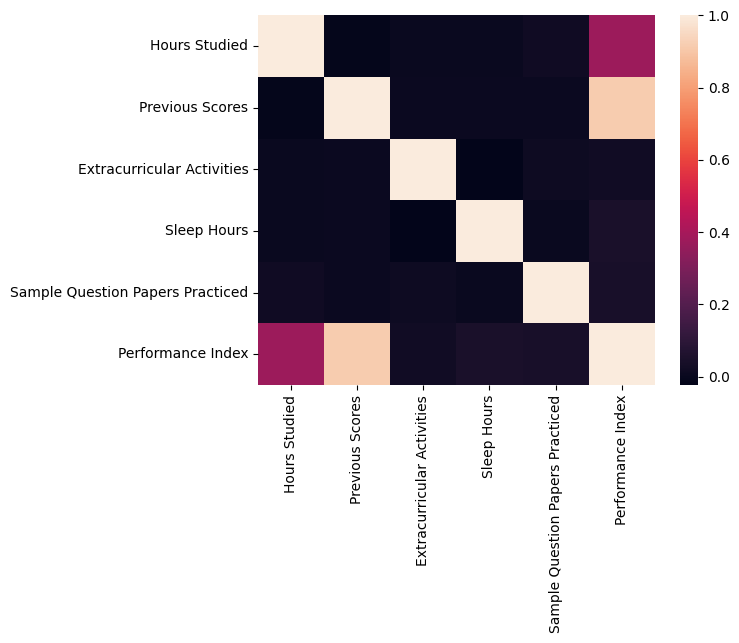

In [ ]:
sns.heatmap(df.corr('pearson'));

Мы увидели, что признаки между собой не коррелируют, так что все хорошо. А вот в плане важности можно ожидать наибольший вклад со стороны признаков "Hours Studied" и "Previous Scores".

Теперь посмотрим на распределение таргета, чтобы понимать, какое значение ошибки считать большим

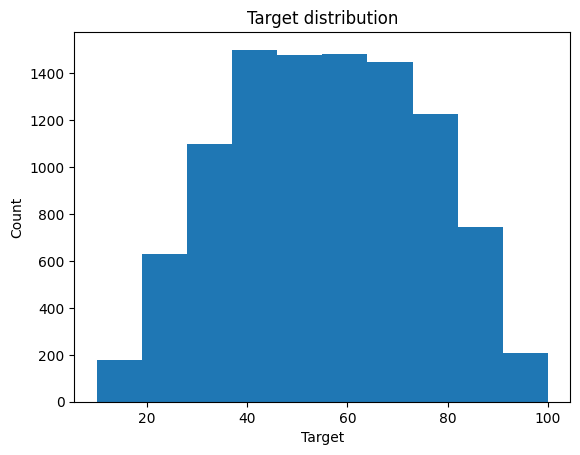

In [ ]:
fig, ax = plt.subplots()
ax.hist(df['Performance Index'])
ax.set_title('Target distribution')
ax.set_xlabel('Target')
ax.set_ylabel('Count');

Поделим наши данные на две выборки (нет гиперпараметров $-$ нет валидации).

In [ ]:
train, test = train_test_split(df, test_size=0.25, random_state=42)
train.shape, test.shape

((7500, 6), (2500, 6))

In [ ]:
x_train, y_train = train.loc[:, :'Sample Question Papers Practiced'].to_numpy(), \
    train['Performance Index'].to_numpy()

x_test, y_test = test.loc[:, :'Sample Question Papers Practiced'].to_numpy(), \
    test['Performance Index'].to_numpy()

Сначала проверим, что будет, если мы для всего предскажем среднее значение по обучающей выборке. Получается, что ошибаемся мы в среднем на 16 баллов (значение средней абсолютной ошибки) и совершенно не учитываем вариантивность ($R^2$ в районе нуля).

In [ ]:
mn = y_train.mean()
pred = [mn for _ in y_test]
r2_score(y_test, pred), mean_absolute_error(y_test, pred)

(-0.001627662324651613, 16.19852352)

Ради интереса проверим, что будет в случае случайной генерации ответа:
- мат. ожидание и стандартное отклонение возьмем по выборке,
- используем нормальное распределение, так как распределение таргета визуально на него похоже

<img src="https://www.scribbr.com/wp-content/uploads/2023/02/standard-normal-distribution-example.webp" width=500>

In [ ]:
pred = np.random.normal(
    loc=y_train.mean(),
    scale=y_train.std(),
    size=y_test.shape
    )

r2_score(y_test, pred), mean_absolute_error(y_test, pred)

(-1.0595519548537062, 22.352380915521632)

Очевидно, все стало хуже. Но зато мы теперь знаем границу, ниже которой падать нельзя :)

Обучим наконец регресию (`score` = $R^2$)

In [ ]:
reg = LinearRegression()
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.9890550757439104

In [ ]:
pred = reg.predict(x_test)
mean_absolute_error(y_test, pred)

1.5975792091646104

Заметим, что все стало сильно лучше. Ошибаемся в среднем на 1.6 (это в 10 раз меньше!) и объсняем значительную часть вариативности ($R^2 = 0.99$)

Теперь попробуем немного проанализировать получившуюся модель. Из нее можно достать веса, сделаем это:

In [ ]:
reg.coef_

array([2.85492123, 1.01637916, 0.58370931, 0.47688351, 0.19092346])

Если теперь соотнести их с признаками из датасета, то станет видно, что наше предположение о важных признаках оказалось правильным:

In [ ]:
for col, coef in zip(df.columns[:-1], reg.coef_):
    print(f'{col}: {round(coef, 3)}')

Hours Studied: 2.855
Previous Scores: 1.016
Extracurricular Activities: 0.584
Sleep Hours: 0.477
Sample Question Papers Practiced: 0.191


## Другие регрессии

Как мы уже сказали, у базовой линейной регрессии есть значительное количество недостатков. По этой причине появились другие виды линейных регрессий, которые позволяют учитывать более сложные зависимости (как полиномиальная) или более стойко переносить выбросы и шум в данных.

### Ridge, Lasso, ElasticNet

Иногда случается такое, что веса модели становятся излишне большими: вместо $y(x_1) = x_1 + 5$ получаем $y(x_1) = 1000 * x_1 - 10000$, которое может неплохо предсказывать на наших данных, но иметь ужасную устойчивость к изменениям (сравните, что произойдет при увеличении $x_1$ на 1 в первом и втором случае). Для того, чтобы этого не происходило, была придумана __регуляризация__.

Чаще всего она заключается в дополнении функции потерь слагаемым, отвечающим за ограничение диапазона для весов. В зависимости от способа ограничения есть три самых частых вида регуляризации:
- Ridge (L2-norm) $-$ сумма квадратов весов
- Lasso (L1-norm) $-$ сумма модулей весов
- ElasticNet $-$ линейная комбинация L1- и L2-нормы

<img src="https://analyticsindiamag.com/wp-content/uploads/2021/08/image-143.png" width=500>

А на наших данных результаты те же, так как задача достаточно простая и признаки хорошие.

In [ ]:
rdg = Ridge(alpha=0.5)
rdg.fit(x_train, y_train)
pred = rdg.predict(x_test)

rdg.score(x_test, y_test), mean_absolute_error(y_test, pred)

(0.9890550526137291, 1.597579615153419)

### Polynomial

Линейная регрессия умеет приближать только линейный зависимости (увы). Но мы можем дать ей возможность работать с более сложными данными, если добавим в признаки комбинации и степени весов.

<img src="https://blog.sf.education/wp-content/uploads/2021/06/1-1.jpg">

Тогда вместо

$y(x_1) = w_1 * x_1 + w_0$

мы можем получить:

$y(x_1) = w_{1,2} * x_1^2 + w_1 * x_1 + w_0$,

что дает нам параболу.



Посмотрим на практике. Для этого заведем игрушечные данные: создадим 1000 точек параболы вида $y = x^2$ и добавим к ним случайного шума

In [ ]:
diff = (-50, 50)
n = 1000

x = np.linspace(*diff, n).reshape(-1, 1)
y = x ** 2  + np.random.normal(0, 100, (n, 1))

Сначада обучим обычную линейную регрессию и увидим, насколько плохо она справляется

In [ ]:
reg = LinearRegression()
reg.fit(x, y)
pred = reg.predict(x)

reg.score(x, y), mean_absolute_error(y, pred)

(6.7940554513423734e-06, 647.5551498577257)

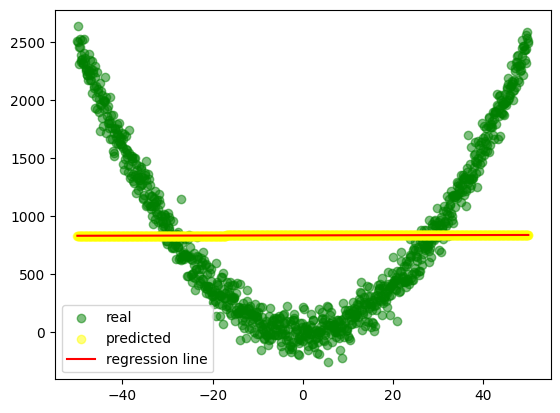

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x, y, color='g', label='real', alpha=0.5)
ax.scatter(x, pred, color='yellow', label='predicted', alpha=0.5)

xs = np.array(diff)
ys = xs * reg.coef_[0,0] + reg.intercept_
ax.plot(xs, ys, color='red', label='regression line')

ax.legend()

plt.show()

А теперь добавим к данным квадрат признака и повторим предыдущее

In [ ]:
new_x = np.hstack([x, x ** 2])

reg = LinearRegression()
reg.fit(new_x, y)
pred = reg.predict(new_x)

reg.score(new_x, y), mean_absolute_error(y, pred)

(0.9828778321221079, 78.06053462350721)

И метрики, и визуализация показывают сильно более высокое качество

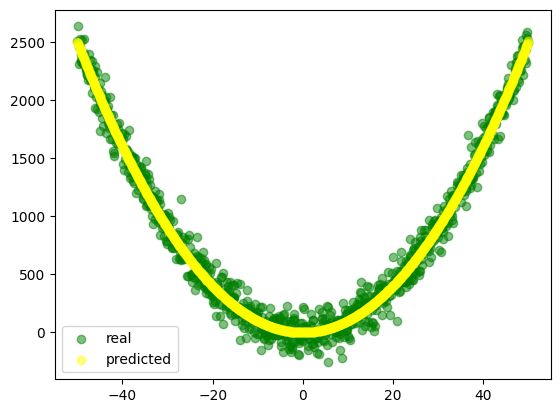

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x, y, color='g', label='real', alpha=0.5)
ax.scatter(x, pred, color='yellow', label='predicted', alpha=0.5)

ax.legend()

plt.show()